In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import time
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('notebook')

In [3]:
from june import World 
from june.demography.geography import Geography
from june.demography import Demography
from june.interaction import Interaction
from june.infection import Infection, HealthIndexGenerator, InfectionSelector
from june.infection.transmission import TransmissionConstant
from june.groups import Hospitals, Schools, Companies, Households, CareHomes, Cemeteries, Universities
from june.groups.leisure import generate_leisure_for_config, Cinemas, Pubs, Groceries
from june.simulator import Simulator
from june.infection_seed import InfectionSeed
from june.policy import Policy, Policies
from june import paths
from june.hdf5_savers import load_geography_from_hdf5
from june.logger.read_logger import ReadLogger
from june.world import generate_world_from_geography
from june.hdf5_savers import generate_world_from_hdf5

No --data argument given - defaulting to:
/home/florpi/JUNE/data
No --configs argument given - defaulting to:
/home/florpi/JUNE/configs


# Initialize world

To initialize a certain world, we need to add the different components we want to have in it. First we specify what super areas (msoa) we want to create. We have included these ones, because they are known to contain hospitals, schools, care homes, and companies.

After creating the geography, we create the different components the worlds need to have such as care homes, companies ...

In [4]:
CONFIG_PATH = paths.configs_path / "config_example.yaml"

In [5]:
%%time 

geography = Geography.from_file(
        {
            "super_area": [
                "E02003282",
                "E02003283",
                "E02001720",
                "E02002560",
                "E02002559",
                "E02004314",
            ]
        }
)

geography.hospitals = Hospitals.for_geography(geography)
geography.schools = Schools.for_geography(geography)
geography.companies = Companies.for_geography(geography)
geography.care_homes = CareHomes.for_geography(geography)
geography.universities = Universities.for_super_areas(geography.super_areas)
world = generate_world_from_geography(geography, include_households=True, include_commute=True)


2020-08-29 13:26:47,915 - june.demography.geography - INFO - There are 162 areas and 6 super_areas in the world.
2020-08-29 13:26:47,926 - june.groups.hospital - INFO - There are 1 hospitals in this geography.
2020-08-29 13:26:48,019 - june.groups.school - INFO - There are 26 schools in this geography.
2020-08-29 13:26:48,079 - june.groups.school - INFO - No school for the age 0 in this world.
2020-08-29 13:26:48,082 - june.groups.school - INFO - No school for the age 1 in this world.
2020-08-29 13:26:48,085 - june.groups.school - INFO - No school for the age 2 in this world.
2020-08-29 13:26:48,474 - june.groups.carehome - INFO - There are 11 care_homes in this geography.
2020-08-29 13:27:00,859 - numexpr.utils - INFO - NumExpr defaulting to 4 threads.
2020-08-29 13:27:05,901 - june.distributors.worker_distributor - INFO - There are 0 who had to be told to stay real
2020-08-29 13:27:29,814 - june.groups.commute.commutehub_distributor - INFO - Distributing people to commute hubs in 11 

## Commute, travel and leisure

In [6]:
world.pubs = Pubs.for_geography(geography)
world.cinemas = Cinemas.for_geography(geography)
world.groceries = Groceries.for_geography(geography)
leisure = generate_leisure_for_config(world, config_filename=CONFIG_PATH)
leisure.distribute_social_venues_to_households(world.households, super_areas=world.super_areas) # this assigns possible social venues to people.

2020-08-29 13:27:31,555 - june.groups.leisure.leisure - INFO - Distributing social venues to households
2020-08-29 13:27:31,556 - june.groups.leisure.leisure - INFO - Distributed in 0 of 20498 households.


We are also going to need some cemeteries...geography.cemeteries = Cemeteries()


In [7]:
world.cemeteries = Cemeteries()

In [8]:
len(world.people)

57259

### If it took a long time to run the previous commands, it might be a good idea to save the world to reuse it later.

In [9]:
world.to_hdf5("world.hdf5")

2020-08-29 13:27:41,519 - june.hdf5_savers.world_saver - INFO - saving world to HDF5
2020-08-29 13:27:42,793 - june.hdf5_savers.world_saver - INFO - saving hospitals...
2020-08-29 13:27:42,796 - june.hdf5_savers.world_saver - INFO - saving schools...
2020-08-29 13:27:42,804 - june.hdf5_savers.world_saver - INFO - saving companies...
2020-08-29 13:27:42,813 - june.hdf5_savers.world_saver - INFO - saving households...
2020-08-29 13:27:43,695 - june.hdf5_savers.world_saver - INFO - saving care homes...
2020-08-29 13:27:43,699 - june.hdf5_savers.world_saver - INFO - saving commute cities...
2020-08-29 13:27:43,704 - june.hdf5_savers.world_saver - INFO - saving commute hubs...
2020-08-29 13:27:43,709 - june.hdf5_savers.world_saver - INFO - saving universities...
2020-08-29 13:27:43,713 - june.hdf5_savers.world_saver - INFO - saving social venues...


If we would like to load the world we saved, we just do

In [10]:
world = generate_world_from_hdf5("world.hdf5")

2020-08-29 13:27:43,759 - june.hdf5_savers.world_saver - INFO - loading world from HDF5
2020-08-29 13:27:43,777 - june.hdf5_savers.world_saver - INFO - loading hospitals...
2020-08-29 13:27:43,781 - june.hdf5_savers.world_saver - INFO - loading schools...
2020-08-29 13:27:43,797 - june.hdf5_savers.world_saver - INFO - loading companies...
2020-08-29 13:27:43,830 - june.hdf5_savers.world_saver - INFO - loading care homes...
2020-08-29 13:27:43,837 - june.hdf5_savers.world_saver - INFO - loading universities...
2020-08-29 13:27:43,843 - june.hdf5_savers.world_saver - INFO - loading commute cities...
2020-08-29 13:27:43,897 - june.hdf5_savers.world_saver - INFO - loading commute hubs...
2020-08-29 13:27:44,019 - june.hdf5_savers.world_saver - INFO - loading households...
2020-08-29 13:27:44,514 - june.hdf5_savers.world_saver - INFO - loading population...
2020-08-29 13:27:44,893 - june.hdf5_savers.world_saver - INFO - loading social venues...
2020-08-29 13:27:44,900 - june.hdf5_savers.wor

In [11]:
# and regenerate leisure in case we load it externally
leisure = generate_leisure_for_config(world, CONFIG_PATH)

you have now a beautiful pre-pandemic world. 

# Adding the infection

The module in charge of infecting people is called the ``InfectionSelector``, which gives people a transmission time profile and a symptoms trajectory based on their age and sex (through the health index generator)

In [12]:
health_index_generator = HealthIndexGenerator.from_file(asymptomatic_ratio=0.2)
selector = InfectionSelector.from_file(
        health_index_generator=health_index_generator,
        transmission_config_path=paths.configs_path / 'defaults/transmission/XNExp.yaml'
)

# Adding the interaction

In [13]:
interaction = Interaction.from_file()

Beta are the intensities of the interaction taking place at the different groups

In [14]:
for key in interaction.beta.keys():
    interaction.beta[key] *= 1.85

In [15]:
interaction.beta

{'box': 1.85,
 'pub': 0.18500000000000003,
 'grocery': 0.18500000000000003,
 'cinema': 0.18500000000000003,
 'commute_unit': 1.85,
 'commute_city_unit': 1.85,
 'hospital': 1.85,
 'care_home': 1.85,
 'company': 0.18500000000000003,
 'school': 0.18500000000000003,
 'household': 0.37000000000000005,
 'university': 0.018500000000000003}

moreover this interaction module uses contact matrices, that are different for different groups. These contact matrices shouldnt be modified for now. However they are a combination of conversational contact matrices, and physical contact matrices (see the BBC pandemic paper, from where these matrices are extracted https://www.medrxiv.org/content/10.1101/2020.02.16.20023754v2)

There is a parameter, ``alpha`` ($\alpha$), that combines these two matrices in the following way,


$\beta M \left(1 + (\alpha -1) \right) P$

where $\beta$ is the intensity of the interaction, and $P$ the physical contact matrix. A larger $\alpha$ produces more physical contacts. It is an overall number, non dependent of the particular group.


In [16]:
interaction.alpha_physical

2.0

# Seed the disease

There are two options implemented in the seed at the moment, either you specify the number of cases and these are then homogeneously distributed by population to the different areas, or you use UK data on cases per region. For now use the first case.

In [17]:
infection_seed = InfectionSeed(
    world.super_areas, selector,
)

In [18]:
n_cases = 30
infection_seed.unleash_virus(n_cases) # play around with the initial number of cases

# Set policies

In [19]:
policies = Policies.from_file()

In [20]:
policies

# Run the simulation

The simulator is the main module in charge of running the simulation. It coordinates the ``ActivityManager`` which is responsible of allocating people to the right groups given the current timestep, it updates the health status of the population, and it runs the interaction over the different groups. All of these modules can be modified by policies at any given time.

Since the timer configuration is a bit cumbersome, it is read from the config file at ``configs/config_example.yaml``

In [21]:
simulator = Simulator.from_file(
    world=world,
    infection_selector=selector,
    interaction=interaction, 
    config_filename = CONFIG_PATH,
    leisure = leisure,
    policies = policies
)

In [22]:
%%time
simulator.run()

2020-08-29 13:27:53,604 - june.simulator - INFO - Starting group_dynamics for 250 days at day 0
2020-08-29 13:27:53,610 - june.simulator - INFO - starting the loop ..., at 0 days, to run for 250 days
2020-08-29 13:27:55,493 - june.simulator - INFO - Date = 2020-03-01 00:00:00, number of deaths =  0, number of infected = 30
2020-08-29 13:27:56,334 - june.simulator - INFO - Date = 2020-03-01 04:00:00, number of deaths =  0, number of infected = 30
2020-08-29 13:27:57,082 - june.simulator - INFO - Date = 2020-03-01 08:00:00, number of deaths =  0, number of infected = 30
2020-08-29 13:27:57,350 - june.simulator - INFO - Date = 2020-03-01 12:00:00, number of deaths =  0, number of infected = 30
2020-08-29 13:27:57,755 - june.simulator - INFO - Date = 2020-03-02 00:00:00, number of deaths =  0, number of infected = 31
2020-08-29 13:27:58,203 - june.simulator - INFO - Date = 2020-03-02 01:00:00, number of deaths =  0, number of infected = 31
2020-08-29 13:27:58,777 - june.simulator - INFO - 

2020-08-29 13:28:31,034 - june.simulator - INFO - Date = 2020-03-14 08:00:00, number of deaths =  0, number of infected = 1505
2020-08-29 13:28:31,355 - june.simulator - INFO - Date = 2020-03-14 12:00:00, number of deaths =  0, number of infected = 1562
2020-08-29 13:28:32,137 - june.simulator - INFO - Date = 2020-03-15 00:00:00, number of deaths =  1, number of infected = 1640
2020-08-29 13:28:32,841 - june.simulator - INFO - Date = 2020-03-15 04:00:00, number of deaths =  1, number of infected = 1686
2020-08-29 13:28:33,534 - june.simulator - INFO - Date = 2020-03-15 08:00:00, number of deaths =  1, number of infected = 1720
2020-08-29 13:28:33,838 - june.simulator - INFO - Date = 2020-03-15 12:00:00, number of deaths =  1, number of infected = 1790
2020-08-29 13:28:34,392 - june.simulator - INFO - Date = 2020-03-16 00:00:00, number of deaths =  3, number of infected = 1894
2020-08-29 13:28:35,083 - june.simulator - INFO - Date = 2020-03-16 01:00:00, number of deaths =  3, number of 

2020-08-29 13:29:29,373 - june.simulator - INFO - Date = 2020-03-28 04:00:00, number of deaths =  28, number of infected = 8171
2020-08-29 13:29:30,301 - june.simulator - INFO - Date = 2020-03-28 08:00:00, number of deaths =  29, number of infected = 8239
2020-08-29 13:29:31,068 - june.simulator - INFO - Date = 2020-03-28 12:00:00, number of deaths =  30, number of infected = 8319
2020-08-29 13:29:32,063 - june.simulator - INFO - Date = 2020-03-29 00:00:00, number of deaths =  31, number of infected = 8512
2020-08-29 13:29:33,026 - june.simulator - INFO - Date = 2020-03-29 04:00:00, number of deaths =  32, number of infected = 8587
2020-08-29 13:29:34,247 - june.simulator - INFO - Date = 2020-03-29 08:00:00, number of deaths =  32, number of infected = 8650
2020-08-29 13:29:35,757 - june.simulator - INFO - Date = 2020-03-29 12:00:00, number of deaths =  32, number of infected = 8721
2020-08-29 13:29:36,678 - june.simulator - INFO - Date = 2020-03-30 00:00:00, number of deaths =  34, nu

2020-08-29 13:30:37,368 - june.simulator - INFO - Date = 2020-04-10 13:00:00, number of deaths =  60, number of infected = 10069
2020-08-29 13:30:38,554 - june.simulator - INFO - Date = 2020-04-11 00:00:00, number of deaths =  60, number of infected = 9972
2020-08-29 13:30:39,566 - june.simulator - INFO - Date = 2020-04-11 04:00:00, number of deaths =  61, number of infected = 9946
2020-08-29 13:30:40,542 - june.simulator - INFO - Date = 2020-04-11 08:00:00, number of deaths =  61, number of infected = 9936
2020-08-29 13:30:41,285 - june.simulator - INFO - Date = 2020-04-11 12:00:00, number of deaths =  61, number of infected = 9887
2020-08-29 13:30:42,294 - june.simulator - INFO - Date = 2020-04-12 00:00:00, number of deaths =  61, number of infected = 9802
2020-08-29 13:30:43,731 - june.simulator - INFO - Date = 2020-04-12 04:00:00, number of deaths =  61, number of infected = 9732
2020-08-29 13:30:45,327 - june.simulator - INFO - Date = 2020-04-12 08:00:00, number of deaths =  62, n

2020-08-29 13:31:40,269 - june.simulator - INFO - Date = 2020-04-24 09:00:00, number of deaths =  78, number of infected = 6751
2020-08-29 13:31:41,531 - june.simulator - INFO - Date = 2020-04-24 10:00:00, number of deaths =  78, number of infected = 6747
2020-08-29 13:31:42,981 - june.simulator - INFO - Date = 2020-04-24 13:00:00, number of deaths =  79, number of infected = 6717
2020-08-29 13:31:44,956 - june.simulator - INFO - Date = 2020-04-25 00:00:00, number of deaths =  80, number of infected = 6617
2020-08-29 13:31:46,913 - june.simulator - INFO - Date = 2020-04-25 04:00:00, number of deaths =  80, number of infected = 6590
2020-08-29 13:31:49,412 - june.simulator - INFO - Date = 2020-04-25 08:00:00, number of deaths =  80, number of infected = 6551
2020-08-29 13:31:50,951 - june.simulator - INFO - Date = 2020-04-25 12:00:00, number of deaths =  80, number of infected = 6513
2020-08-29 13:31:52,614 - june.simulator - INFO - Date = 2020-04-26 00:00:00, number of deaths =  80, nu

2020-08-29 13:32:52,214 - june.simulator - INFO - Date = 2020-05-08 01:00:00, number of deaths =  90, number of infected = 3581
2020-08-29 13:32:53,199 - june.simulator - INFO - Date = 2020-05-08 09:00:00, number of deaths =  90, number of infected = 3512
2020-08-29 13:32:54,211 - june.simulator - INFO - Date = 2020-05-08 10:00:00, number of deaths =  90, number of infected = 3499
2020-08-29 13:32:54,953 - june.simulator - INFO - Date = 2020-05-08 13:00:00, number of deaths =  90, number of infected = 3466
2020-08-29 13:32:55,985 - june.simulator - INFO - Date = 2020-05-09 00:00:00, number of deaths =  90, number of infected = 3375
2020-08-29 13:32:57,005 - june.simulator - INFO - Date = 2020-05-09 04:00:00, number of deaths =  90, number of infected = 3345
2020-08-29 13:32:58,084 - june.simulator - INFO - Date = 2020-05-09 08:00:00, number of deaths =  91, number of infected = 3298
2020-08-29 13:32:59,052 - june.simulator - INFO - Date = 2020-05-09 12:00:00, number of deaths =  91, nu

2020-08-29 13:33:56,461 - june.simulator - INFO - Date = 2020-05-22 00:00:00, number of deaths =  97, number of infected = 1192
2020-08-29 13:33:57,528 - june.simulator - INFO - Date = 2020-05-22 01:00:00, number of deaths =  97, number of infected = 1187
2020-08-29 13:33:58,295 - june.simulator - INFO - Date = 2020-05-22 09:00:00, number of deaths =  97, number of infected = 1143
2020-08-29 13:33:59,792 - june.simulator - INFO - Date = 2020-05-22 10:00:00, number of deaths =  97, number of infected = 1140
2020-08-29 13:34:00,507 - june.simulator - INFO - Date = 2020-05-22 13:00:00, number of deaths =  97, number of infected = 1126
2020-08-29 13:34:01,443 - june.simulator - INFO - Date = 2020-05-23 00:00:00, number of deaths =  97, number of infected = 1089
2020-08-29 13:34:02,360 - june.simulator - INFO - Date = 2020-05-23 04:00:00, number of deaths =  97, number of infected = 1068
2020-08-29 13:34:03,274 - june.simulator - INFO - Date = 2020-05-23 08:00:00, number of deaths =  97, nu

2020-08-29 13:34:52,316 - june.simulator - INFO - Date = 2020-06-04 13:00:00, number of deaths =  97, number of infected = 302
2020-08-29 13:34:53,049 - june.simulator - INFO - Date = 2020-06-05 00:00:00, number of deaths =  97, number of infected = 283
2020-08-29 13:34:54,388 - june.simulator - INFO - Date = 2020-06-05 01:00:00, number of deaths =  97, number of infected = 280
2020-08-29 13:34:55,063 - june.simulator - INFO - Date = 2020-06-05 09:00:00, number of deaths =  97, number of infected = 269
2020-08-29 13:34:55,997 - june.simulator - INFO - Date = 2020-06-05 10:00:00, number of deaths =  97, number of infected = 269
2020-08-29 13:34:56,635 - june.simulator - INFO - Date = 2020-06-05 13:00:00, number of deaths =  97, number of infected = 265
2020-08-29 13:34:57,502 - june.simulator - INFO - Date = 2020-06-06 00:00:00, number of deaths =  97, number of infected = 255
2020-08-29 13:34:58,375 - june.simulator - INFO - Date = 2020-06-06 04:00:00, number of deaths =  97, number of

2020-08-29 13:35:47,599 - june.simulator - INFO - Date = 2020-06-18 10:00:00, number of deaths =  98, number of infected = 46
2020-08-29 13:35:48,239 - june.simulator - INFO - Date = 2020-06-18 13:00:00, number of deaths =  98, number of infected = 45
2020-08-29 13:35:48,895 - june.simulator - INFO - Date = 2020-06-19 00:00:00, number of deaths =  98, number of infected = 43
2020-08-29 13:35:49,922 - june.simulator - INFO - Date = 2020-06-19 01:00:00, number of deaths =  98, number of infected = 43
2020-08-29 13:35:50,579 - june.simulator - INFO - Date = 2020-06-19 09:00:00, number of deaths =  98, number of infected = 43
2020-08-29 13:35:51,470 - june.simulator - INFO - Date = 2020-06-19 10:00:00, number of deaths =  98, number of infected = 43
2020-08-29 13:35:52,197 - june.simulator - INFO - Date = 2020-06-19 13:00:00, number of deaths =  98, number of infected = 43
2020-08-29 13:35:53,098 - june.simulator - INFO - Date = 2020-06-20 00:00:00, number of deaths =  98, number of infect

2020-08-29 13:36:40,781 - june.simulator - INFO - Date = 2020-07-02 10:00:00, number of deaths =  98, number of infected = 1
2020-08-29 13:36:41,415 - june.simulator - INFO - Date = 2020-07-02 13:00:00, number of deaths =  98, number of infected = 1
2020-08-29 13:36:42,076 - june.simulator - INFO - Date = 2020-07-03 00:00:00, number of deaths =  98, number of infected = 1
2020-08-29 13:36:43,072 - june.simulator - INFO - Date = 2020-07-03 01:00:00, number of deaths =  98, number of infected = 1
2020-08-29 13:36:43,725 - june.simulator - INFO - Date = 2020-07-03 09:00:00, number of deaths =  98, number of infected = 1
2020-08-29 13:36:44,873 - june.simulator - INFO - Date = 2020-07-03 10:00:00, number of deaths =  98, number of infected = 1
2020-08-29 13:36:45,892 - june.simulator - INFO - Date = 2020-07-03 13:00:00, number of deaths =  98, number of infected = 1
2020-08-29 13:36:46,832 - june.simulator - INFO - Date = 2020-07-04 00:00:00, number of deaths =  98, number of infected = 1


KeyboardInterrupt: 

While the simulation runs (and afterwards) we can launch the visualization webpage by running
```python june/visualizer.py path/to/results``` 

# Getting the results

All results are stored in a json file specified in the ``save_path`` variable in the config file. We can also access it from ``world.logger`` directly.

In [ ]:
import pandas as pd

In [36]:
read = ReadLogger()

## Hospital data and how it changed over time

In [37]:
hospitals_df = read.load_hospital_capacity()

In [38]:
hospitals_df.head(3)

,time_stamp,id,n_patients,n_patients_icu
0,2020-03-01T00:00:00.000000,0,0,0
1,2020-03-01T04:00:00.000000,0,0,0
2,2020-03-01T08:00:00.000000,0,0,0


In [39]:
hospitals_characteristics_df = read.load_hospital_characteristics()

In [40]:
hospitals_characteristics_df

,longitude,latitude,n_beds,n_icu_beds,trust_code
0,0.688477,51.5625,2115,296,RAJ


## where did infections happen?

In [65]:
loc_df = read.get_locations_infections()

In [66]:
unique_super_areas = np.unique(read.super_areas)

In [67]:
read.locations_df["super_areas"] = read.locations_df.apply(    
    lambda x: read.super_areas[x.new_infected_ids], axis=1    
)

In [68]:
read.locations_df

,location,new_infected_ids,super_areas
time_stamp,,,
2020-03-01 00:00:00,[],[],[]
2020-03-01 04:00:00,[],[],[]
2020-03-01 08:00:00,[],[],[]
2020-03-01 12:00:00,[household_451],[16965],[E02002559]
2020-03-02 00:00:00,[],[],[]
...,...,...,...
2020-07-14 01:00:00,[],[],[]
2020-07-14 09:00:00,[],[],[]
2020-07-14 10:00:00,[],[],[]


In [63]:
read.locations_df.resample('D').sum()

,location,new_infected_ids
time_stamp,,
2020-03-01,[household_451],[16965]
2020-03-02,"[household_451, care_home_8]","[17069, 54483]"
2020-03-03,"[school_9, school_9, school_9, school_12, scho...","[38715, 34866, 39953, 16956, 16968, 23500, 523..."
2020-03-04,"[school_9, company_549, care_home_8, household...","[40603, 8066, 54451, 1833, 16949, 54457, 54471..."
2020-03-05,"[household_604, school_9, school_12, company_5...","[20954, 38726, 42348, 14158, 11232, 12211, 122..."
...,...,...
2020-07-11,[],[]
2020-07-12,[],[]
2020-07-13,[],[]


In [31]:
loc_df

['household_451',
 'household_451',
 'care_home_8',
 'school_9',
 'school_9',
 'school_9',
 'school_12',
 'school_12',
 'company_2095',
 'company_2095',
 'care_home_8',
 'care_home_8',
 'care_home_8',
 'household_980',
 'household_105',
 'household_169',
 'household_171',
 'school_9',
 'company_549',
 'care_home_8',
 'household_449',
 'household_449',
 'care_home_8',
 'care_home_8',
 'care_home_8',
 'household_604',
 'school_9',
 'school_12',
 'company_549',
 'company_1913',
 'care_home_1',
 'care_home_1',
 'care_home_1',
 'care_home_8',
 'care_home_8',
 'care_home_8',
 'care_home_8',
 'care_home_8',
 'care_home_8',
 'care_home_8',
 'care_home_8',
 'care_home_8',
 'care_home_8',
 'care_home_8',
 'care_home_8',
 'care_home_8',
 'care_home_8',
 'care_home_8',
 'grocery_7',
 'household_451',
 'household_604',
 'care_home_1',
 'care_home_8',
 'care_home_8',
 'care_home_8',
 'care_home_8',
 'care_home_8',
 'household_117',
 'care_home_8',
 'care_home_8',
 'care_home_8',
 'care_home_8',
 'ca

In [32]:
locations_per_day = read.locations_df.groupby(pd.Grouper(freq='D')).sum()

In [33]:
all_infection_places = set(locations_per_day.location.sum())

In [34]:
def n_infections(row, infection_place):
    return sum([row.counts[i] for i, x in enumerate(row.location) if x == infection_place])


In [35]:
for infection_place in all_infection_places:
    locations_per_day[str(infection_place)] = locations_per_day.apply(
        lambda x: n_infections(x, infection_place),
        axis=1
    )

AttributeError: 'Series' object has no attribute 'counts'

In [ ]:
locations_per_day = locations_per_day.drop(columns=['location',
                                                    'counts'])

In [ ]:
locations_per_day = locations_per_day.div(
    locations_per_day.sum(axis=1), axis=0
)


In [ ]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 100

In [ ]:
locations_per_day.plot.area( alpha=0.5)
plt.legend(bbox_to_anchor=(1,1))
plt.ylabel('Percent of infections')

In [ ]:
from matplotlib import cm
cmap = cm.get_cmap('Spectral') # Colour map (there are many others)

locations_per_day.plot(figsize=(30,8), logy=True, ylim=(1e-3, 1), cmap=cmap)

In [ ]:
import matplotlib.ticker as mtick

ax = loc_df['percentage_infections'].sort_values().plot.bar()
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
plt.ylabel('Percentage of infections at location')
plt.xlabel('location')
#plt.yscale('log')

## rate of infection

In [ ]:
r_df = read.get_r()

In [ ]:
from june.policy import SocialDistancing
r_df.plot()
colors = ["yellow", "orange", 'blue']
for policy in policies.policies:
    if isinstance(policy, SocialDistancing):
        plt.axvspan(policy.start_time, 
                policy.end_time,
                facecolor=colors.pop(),
                alpha=0.2)
plt.axhline(y=1, linestyle='dashed', color='gray')
plt.xlabel('Date')
plt.ylim(0,3)
plt.ylabel('R')

## World infection curves, and by super area

In [47]:
world_df = read.world_summary()

In [48]:
world_df['new_infections'].sum()/len(world.people)

0.31781903281580187

In [49]:
len(world.people)

57259

Text(0.5, 0, 'Date')

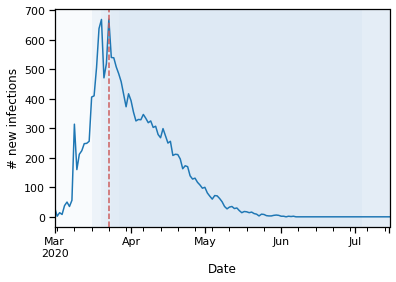

In [50]:
fig, ax = plt.subplots()
world_df['new_infections'].resample('D').sum().plot(ax=ax)
for policy in policies.policies:
    plt.axvspan(policy.start_time, 
                policy.end_time,
                alpha=0.01)
plt.axvline('2020-03-23',
           linestyle='dashed',
           color='indianred')
ax.set_ylabel('# new infections')
ax.set_xlabel('Date')

Text(0.5, 0, 'Date')

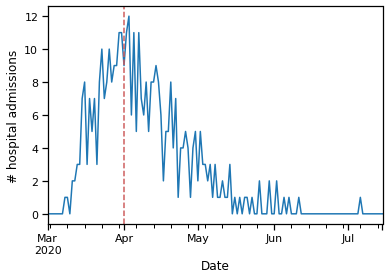

In [52]:
fig, ax = plt.subplots()
(world_df['hospital_admissions']+world_df['intensive_care_admissions']).resample('D').sum().plot(ax=ax)

plt.axvline('2020-04-01',
           linestyle='dashed',
           color='indianred')
ax.set_ylabel('# hospital admissions')
ax.set_xlabel('Date')

Text(0.5, 0, 'Date')

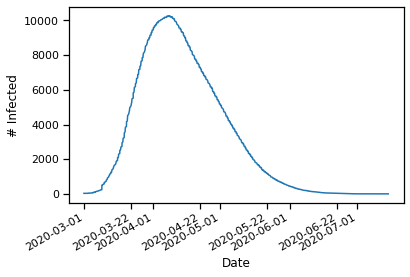

In [53]:
fig, ax = plt.subplots()
world_df['infected'].plot(ax=ax)

ax.set_ylabel('# Infected')
ax.set_xlabel('Date')

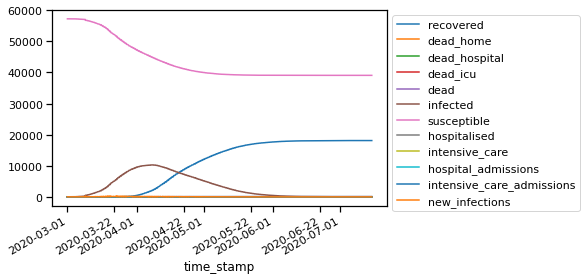

In [54]:
world_df.plot()

plt.legend(bbox_to_anchor=(1,1))


In [ ]:
area_df = read.super_area_summary()

In [ ]:
area_df[area_df.super_area == "E02003282"].plot()
plt.legend(bbox_to_anchor=(1,1))

## World infection curves per age group

In [ ]:
ages_df = read.age_summary([0,10,20,30,40,
                  50,60,70,80,90,100])

In [ ]:
for name, group in ages_df.groupby('age_range'):
    group['infected'].plot(label=name)
colors = ["yellow", "orange"]
for policy in policies.policies:
    if isinstance(policy, SocialDistancing):
        plt.axvspan(policy.start_time, 
                policy.end_time,
                facecolor=colors.pop(), alpha=0.2)
plt.legend(bbox_to_anchor=(1,1))


In [ ]:
for name, group in ages_df.groupby('age_range'):
    group['dead'].cumsum().plot(label=name)
plt.legend()

In [ ]:
for name, group in ages_df.groupby('age_range'):
    group['susceptible'].plot(label=name)
plt.legend()

In [ ]:
for name, group in ages_df.groupby('age_range'):
    group['hospital_admissions'].cumsum().plot(label=name)
plt.legend()

In [ ]:
for name, group in ages_df.groupby('age_range'):
    group['intensive_care_admissions'].cumsum().plot(label=name)
plt.legend()

## Draw some of the symptoms trajectories

In [ ]:
random_trajectories = read.draw_symptom_trajectories(window_length=600,
                                        n_people=10)

In [ ]:
from june.infection import SymptomTag

In [ ]:
symptoms_values = [tag.value for tag in SymptomTag]
symptoms_names = [tag.name for tag in SymptomTag]


In [ ]:
for df_person in random_trajectories:
    df_person['symptoms'].plot()
plt.ylabel('Symptoms Trajectory')
_ = plt.yticks(symptoms_values, symptoms_names)
plt.xlabel('Date')

In [ ]:
for df_person in random_trajectories:
    df_person['n_secondary_infections'].plot()
plt.ylabel('Number of secondary infections')

plt.xlabel('Date')

In [ ]:
person.primary_activity.group.spec